<a href="https://colab.research.google.com/github/Umer1farooq/AI-Project/blob/main/NoteBooks/Phase_1_%E2%80%94_Data_Loading_%26_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install required packages

In [1]:
# ===== PHASE 1 — STEP 1 =====
# Install required packages

!pip install -q kaggle
!pip install -q tensorflow keras numpy matplotlib seaborn scikit-learn pillow pandas


In [2]:
from google.colab import files, drive
import os, shutil

# Mount Google Drive
drive.mount('/content/drive')

print("Upload kaggle.json (Kaggle → Account → API → Create New Token)")
uploaded = files.upload()   # Select kaggle.json file

for fn in uploaded.keys():
    print('Uploaded:', fn)

# Move kaggle.json to correct directory
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("kaggle.json moved to /root/.kaggle/kaggle.json")


Mounted at /content/drive
Upload kaggle.json (Kaggle → Account → API → Create New Token)


Saving kaggle.json to kaggle.json
Uploaded: kaggle.json
kaggle.json moved to /root/.kaggle/kaggle.json


In [5]:
# ===== PHASE 1 — STEP 3 =====
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data
License(s): CC0-1.0
 72% 171M/238M [00:00<00:00, 1.71GB/s]
100% 238M/238M [00:00<00:00, 906MB/s] 


In [7]:
import shutil, os

src = '/content/colored_images'   # main dataset folder
dst = '/content/drive/MyDrive/datasets/diabetic_retinopathy_2019/color'

os.makedirs(dst, exist_ok=True)

def copy_tree(src, dst):
    for root, dirs, files in os.walk(src):
        rel = os.path.relpath(root, src)
        target_root = os.path.join(dst, rel)
        os.makedirs(target_root, exist_ok=True)
        for f in files:
            sfile = os.path.join(root, f)
            tfile = os.path.join(target_root, f)
            if not os.path.exists(tfile):
                shutil.copy2(sfile, tfile)

if os.path.exists(src):
    copy_tree(src, dst)
    print("Dataset successfully copied to Drive:", dst)
else:
    print("Source folder does NOT exist:", src)


Dataset successfully copied to Drive: /content/drive/MyDrive/datasets/diabetic_retinopathy_2019/color


In [8]:
import os

base = '/content/drive/MyDrive/datasets/diabetic_retinopathy_2019/color'

print("===== IMAGE COUNTS =====")
for cls in sorted(os.listdir(base)):
    cls_path = os.path.join(base, cls)
    if os.path.isdir(cls_path):
        n = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"{cls}: {n}")


===== IMAGE COUNTS =====
Mild: 370
Moderate: 999
No_DR: 1805
Proliferate_DR: 295
Severe: 193


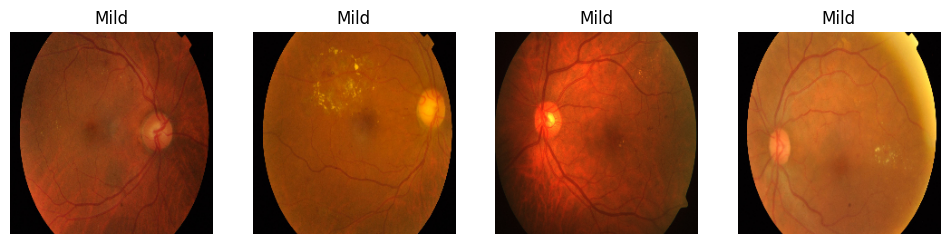

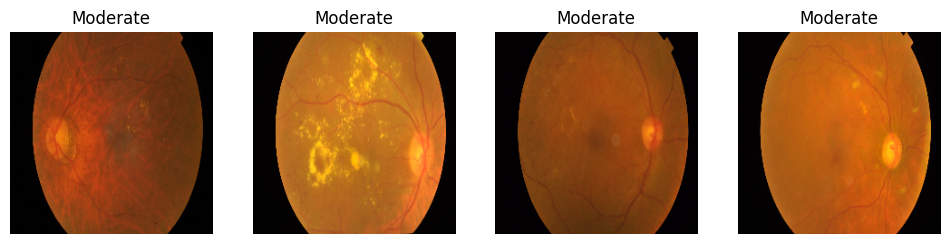

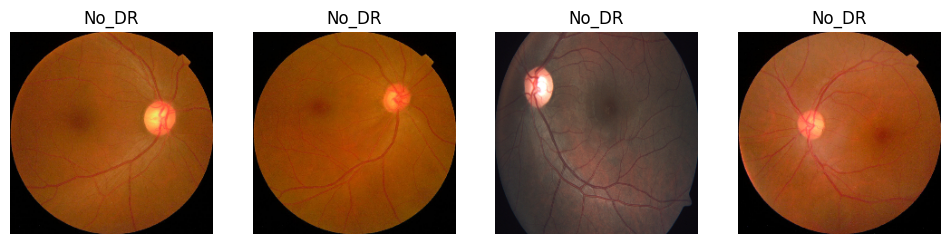

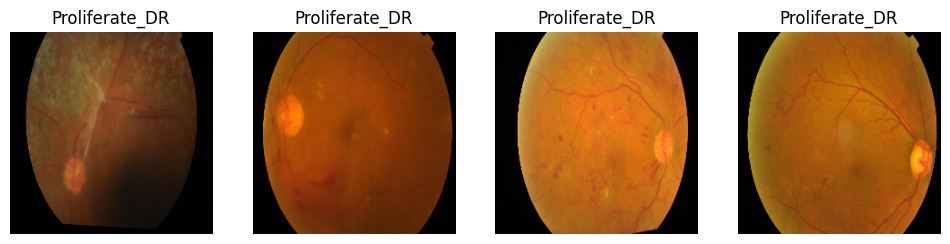

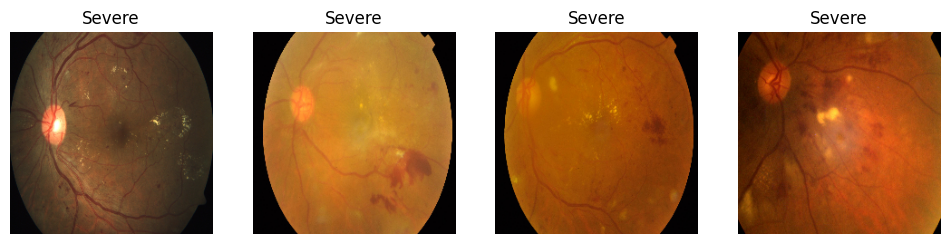

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import random, os

base = '/content/drive/MyDrive/datasets/diabetic_retinopathy_2019/color'

def show_samples(n=4):
    classes = sorted(os.listdir(base))
    for cls in classes:
        folder = os.path.join(base, cls)
        imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]

        sampled = random.sample(imgs, min(n, len(imgs)))
        plt.figure(figsize=(12,3))

        for i, imgfile in enumerate(sampled):
            img = Image.open(os.path.join(folder, imgfile)).convert('RGB')
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
        plt.show()

show_samples()


In [10]:
from PIL import Image
from collections import Counter

base = '/content/drive/MyDrive/datasets/diabetic_retinopathy_2019/color'

sizes = Counter()

for cls in os.listdir(base):
    folder = os.path.join(base, cls)
    for fn in os.listdir(folder):
        if fn.lower().endswith(('.png','.jpg','.jpeg')):
            img = Image.open(os.path.join(folder, fn))
            sizes[img.size] += 1

print("Most common image sizes:")
for s, c in sizes.most_common(10):
    print(s, c)


Most common image sizes:
(224, 224) 3662


In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_src = '/content/drive/MyDrive/datasets/diabetic_retinopathy_2019/color'
base_dst = '/content/drive/MyDrive/datasets/diabetic_retinopathy_2019/splitted'

train_dir = os.path.join(base_dst, 'train')
val_dir = os.path.join(base_dst, 'val')
test_dir = os.path.join(base_dst, 'test')

# Create directories
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

classes = sorted(os.listdir(base_src))

for cls in classes:
    cls_src = os.path.join(base_src, cls)
    images = [f for f in os.listdir(cls_src) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    # train/val/test split
    train_files, temp_files = train_test_split(images, test_size=0.30, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.50, random_state=42)

    # Make class folders
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(cls_src, f), os.path.join(train_dir, cls, f))

    for f in val_files:
        shutil.copy(os.path.join(cls_src, f), os.path.join(val_dir, cls, f))

    for f in test_files:
        shutil.copy(os.path.join(cls_src, f), os.path.join(test_dir, cls, f))

print("Dataset successfully split into Train / Val / Test!")


Dataset successfully split into Train / Val / Test!


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

train_gen.class_indices


Found 2562 images belonging to 5 classes.
Found 549 images belonging to 5 classes.
Found 551 images belonging to 5 classes.


{'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}

In [13]:
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples:", test_gen.samples)


Train samples: 2562
Validation samples: 549
Test samples: 551
